# Demonstration of HyPyP basics

Authors          : Guillaume Dumas, Anaël Ayrolles, Florence Brun

Date            : 2020-06-03

## Load useful libs

### Core

In [1]:
import io
from copy import copy
from collections import OrderedDict
import requests

### Data science

In [2]:
import numpy as np
import scipy

### Visualization

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

### MNE

In [4]:
import mne

### HyPyP

In [5]:
from hypyp import prep # need pip install https://api.github.com/repos/autoreject/autoreject/zipball/master
from hypyp import analyses
from hypyp import stats
from hypyp import viz

## Setting parameters

Frequency bands used in the study

In [6]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

Keep the order of frequency bands in the dictionary

In [7]:
freq_bands = OrderedDict(freq_bands)

## Load data

Loading datasets (see MNE functions mne.io.read_raw_format), convert them to MNE Epochs.

In our example, we load Epochs directly from EEG dataset in the fiff format

In [8]:
URL_TEMPLATE = "https://github.com/GHFC/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_data(idx):
    return io.BytesIO(requests.get(URL_TEMPLATE.format(idx)).content)

epo1 = mne.read_epochs(
    get_data(1),
    preload=True,
) 

epo2 = mne.read_epochs(
    get_data(2),
    preload=True,
) 


Reading File-like <_io.BytesIO object at 0x11dbb9b30> ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
260 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Reading File-like <_io.BytesIO object at 0x11dc03890> ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
36 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [9]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

Specify sampling frequency

In [10]:
sampling_rate = epo1.info['sfreq'] #Hz

## Preprocessing epochs

### ICA correction

Computing global AutoReject and Independant Components Analysis for each participant

In [11]:
icas = prep.ICA_fit([epo1, epo2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state=42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 0.00010129807784293706}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 10.7s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 7.5s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 4.747409473367548e-05}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 7.7s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 7.3s.


Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both

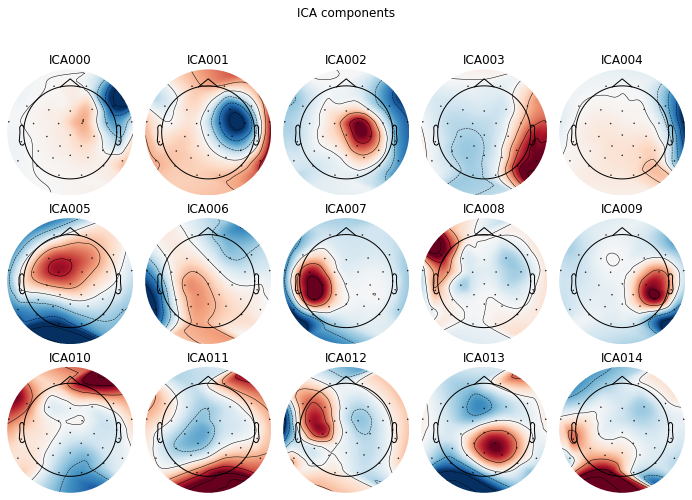

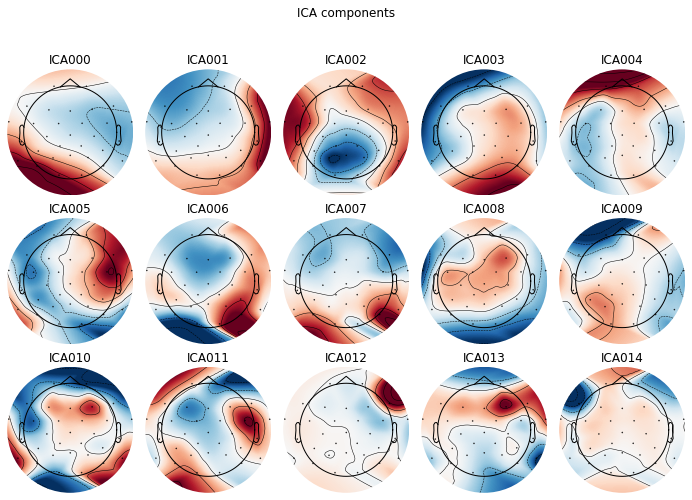

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. (If you do not want to apply ICA on your data, do not enter nothing and press enter.)
Which IC do you want to use as a template? Index begins at zero. (If you did not choosea participant number at first question,then do not enter nothing and press enter againto not apply ICA on your data)


In [12]:
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])

### Autoreject

Applying local AutoReject for each participant rejecting bad epochs, rejecting or interpolating partially bad channels removing the same bad channels and epochs across participants plotting signal before and after (verbose=True)

Running autoreject on ch_type=eeg








Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg








Estimated consensus=0.20 and n_interpolate=1
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20



No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs


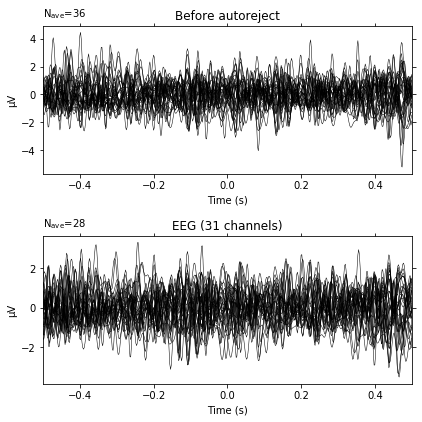

<Figure size 432x288 with 0 Axes>

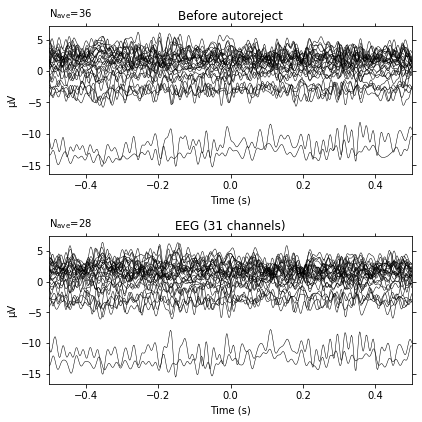

<Figure size 432x288 with 0 Axes>

In [30]:
cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

### Picking the preprocessed epochs for each participant

In [14]:
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

## Analysing data

### Welch Power Spectral Density

Here for ex, the frequency-band-of-interest is restricted to Alpha_Low, frequencies for which power spectral density is actually computed are returned in freq_list, and PSD values are averaged across epochs

In [15]:
psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


### Connectivity

Initializing data and storage

In [16]:
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

Computing analytic signal per frequency band

In [17]:
complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate,
                                             freq_bands)

/Users/ayrolles/DEV/HyPyP/hypyp/analyses.py:518: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/Users/ayrolles/DEV/HyPyP/hypyp/analyses.py:518: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/Users/ayrolles/DEV/HyPyP/hypyp/analyses.py:518: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/Users/ayrolles/DEV/HyPyP/hypyp/analyses.py:518: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/Users/ayrolles/DEV/HyPyP/hypyp/analyses.py:518: RuntimeWarning: filter_length (575) is longer than the signal (501), distortion

Computing frequency- and time-frequency-domain connectivity, 'ccorr' for example

In [18]:
result = analyses.compute_sync(complex_signal, mode='ccorr')

Slicing results to get the Inter-brain part of the matrix

In [19]:
n_ch = len(epo1.info['ch_names'])
theta, alpha_low, alpha_high, beta, gamma = result[:, 0:n_ch, n_ch:2*n_ch]

Choosing Alpha_Low for futher analyses for example

In [20]:
values = alpha_low
values -= np.diag(np.diag(values))

Computing Cohens'D for further analyses for example

In [21]:
C = (values - np.mean(values[:])) / np.std(values[:])

Slicing results to get the Intra-brain part of the matrix

In [22]:
for i in [0, 1]:
    theta, alpha_low, alpha_high, beta, gamma = result[:, i:i+n_ch, i:i+n_ch]
    # choosing Alpha_Low for futher analyses for example
    values_intra = alpha_low
    values_intra -= np.diag(np.diag(values_intra))
    # computing Cohens'D for further analyses for example
    C_intra = (values_intra -
               np.mean(values_intra[:])) / np.std(values_intra[:])
    # can also sample CSD values directly for statistical analyses
    result_intra.append(C_intra)

## Statistical analyses

### Comparing PSD values to random signal

Parametric t test

#### 1/ MNE test without any correction

This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension

In [23]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)

Permuting 1 times (exact test)...


In [ ]:
#### 2/ HyPyP parametric t test with bonferrroni correction

Based on MNE function, the same things as above are true. 
FDR correction for multiple comparisons is added.

In [24]:
statsCondTuple = stats.statsCond(data=data_psd,
                                 epochs=preproc_S1,
                                 n_permutations=5000,
                                 alpha=0.05)

Permuting 1 times (exact test)...


#### 3/ Non-parametric cluster-based permutations

Creating matrix of a priori connectivity between channels across space and frequencies based on their position, in the Alpha_Low band for example

In [25]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 31


Creating two fake groups with twice the 'participant1' and twice the 'participant1'

In [26]:
data_group = [np.array([psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd])]

statscondCluster = stats.statscondCluster(data=data_group,
                                          freqs_mean=psd1.freq_list,
                                          ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering
Found 1 clusters


/home/igrec/Dev/Pasteur/SoNeTAA/HyPyP/hypyp/stats.py:343: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')
/home/igrec/.cache/pypoetry/virtualenvs/hypyp-zNGE6Swh-py3.6/lib/python3.6/site-packages/mne/stats/parametric.py:128: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Permuting 4999 times...


/home/igrec/.cache/pypoetry/virtualenvs/hypyp-zNGE6Swh-py3.6/lib/python3.6/site-packages/mne/stats/parametric.py:128: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw



Computing cluster p-values
Done.


### Comparing Intra-brain connectivity values between participants

With 3/ non-parametric cluster-based permutations creating matrix of a priori connectivity between channels across space and frequencies based on their position

In [27]:
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1, freqs_mean=np.arange(7.5, 11), draw=False)

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 31


Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [28]:
ch_con = con_matrixTuple.ch_con

Create again two fake groups with twice the 'participant1' and twice the 'participant2'

In Alpha_Low band for example (see above):

In [29]:
Alpha_Low = [np.array([result_intra[0], result_intra[0]]),
             np.array([result_intra[1], result_intra[1]])]

statscondCluster_intra = stats.statscondCluster(data=Alpha_Low,
                                                freqs_mean=np.arange(7.5, 11),
                                                ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
                                                tail=0,
                                                n_permutations=5000,
                                                alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering
Found 1 clusters


/home/igrec/Dev/Pasteur/SoNeTAA/HyPyP/hypyp/stats.py:343: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')


Permuting 4999 times...



Computing cluster p-values
Done.


### Comparing Inter-brain connectivity values to random signal

No a priori connectivity between channels is considered between the two participants

In Alpha_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [30]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=np.arange(7.5, 11),
                                          ch_con_freq=None,
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering
Found 1 clusters
Permuting 4999 times...


/home/igrec/Dev/Pasteur/SoNeTAA/HyPyP/hypyp/stats.py:343: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')



Computing cluster p-values
Done.


## Visualization

### Visualization of T values for sensors

for 1/ ```T_obs_plot = T_obs```

for 2/ ```statsCondTuple.T_obs```

for 3/ ```statscondCluster.F_obs_plot```

In [31]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs, epochs=preproc_S1)

### Vizualize T values for significant sensors only

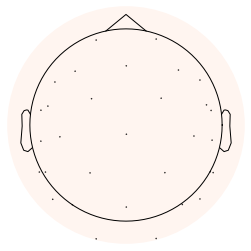

In [32]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot, epochs=preproc_S1)

### Visulization of inter-brain links projected

on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [33]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

### Visualisation of brain connectivity in 2D and 3D

Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, 
it is calculated specifically for the dyad, 
and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

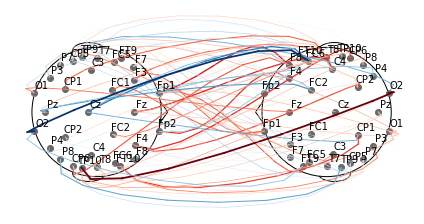

In [24]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold='auto', steps=10, lab=True)


#### Visualization of inter-brain connectivity in 3D


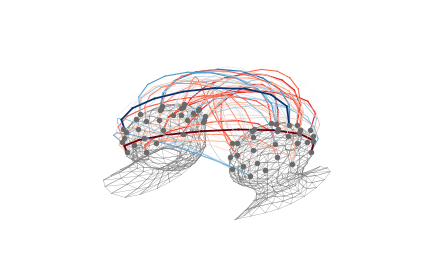

In [25]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)


#### Visualization of intra-brain connectivity in 2D

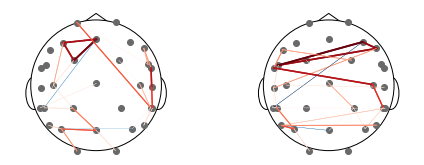

In [27]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

#### Visualization of intra-brain connectivity in 3D

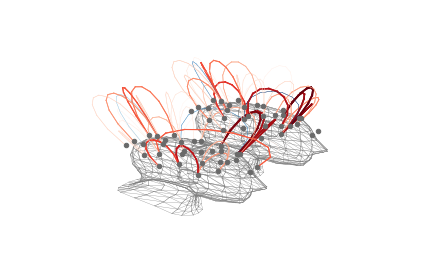

In [29]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)